In [307]:
import pandas as pd

url_1 = "https://raw.githubusercontent.com/Han020306/006-Data-Science/main/obesity_rate.xlsx"

obesity_rate = pd.read_excel(url_1, engine="openpyxl")
print(obesity_rate.head())


        Code            Name  Obesity_rate
0  E09000001  City of London      0.000000
1  E05000026           Abbey      0.247166
2  E05000027          Alibon      0.259953
3  E05000028       Becontree      0.292585
4  E05000029  Chadwell Heath      0.245856


In [309]:
import pandas as pd

url_2 = "https://raw.githubusercontent.com/Han020306/006-Data-Science/main/ward_data.xlsx"

ward_data = pd.read_excel(url_2, engine="openpyxl")
print(ward_data.head())

                               Ward name Old code   New code  \
0                         City of London     00AA  E09000001   
1           Barking and Dagenham - Abbey   00ABFX  E05000026   
2          Barking and Dagenham - Alibon   00ABFY  E05000027   
3       Barking and Dagenham - Becontree   00ABFZ  E05000028   
4  Barking and Dagenham - Chadwell Heath   00ABGA  E05000029   

  Employment rate (16-64) - 2011 Median House Price (£) - 2014  \
0                      79.632867                        765000   
1                      60.348077                        173000   
2                      63.107388                        215000   
3                      61.192441                        210000   
4                      63.639393                        240500   

  Population density (persons per sq km) - 2013  \
0                                   2538.062371   
1                                         10500   
2                                        7428.6   
3             

<Axes: >

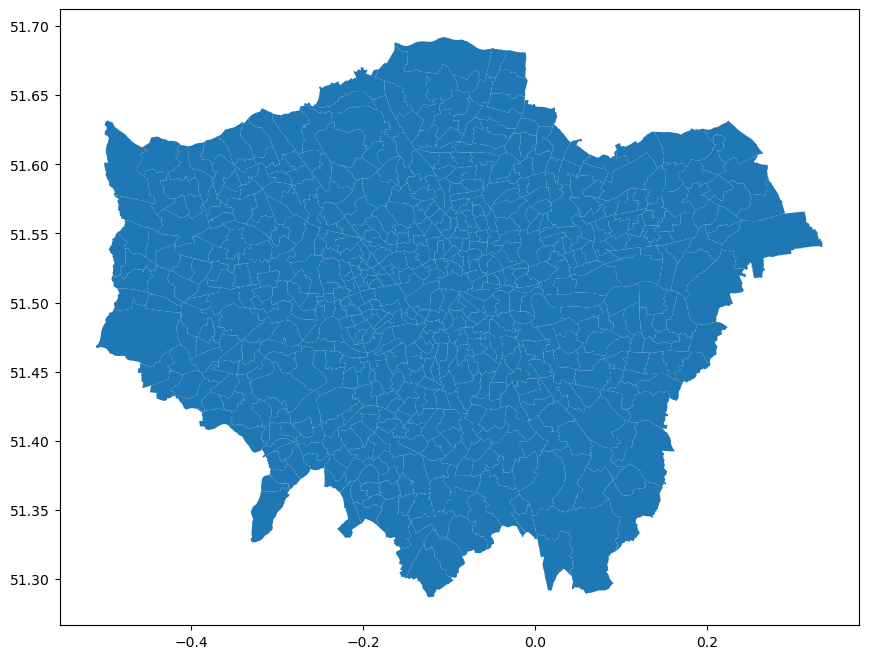

In [311]:
import geopandas as gpd

url_3 = "https://raw.githubusercontent.com/Han020306/006-Data-Science/main/ward_boundary.geojson"
ward_boundary = gpd.read_file(url_3)

ward_boundary.head()
ward_boundary.plot()


In [187]:
from sklearn.preprocessing import StandardScaler

# 合并两个数据框
merged = pd.merge(ward_data, obesity_rate, left_on="New code", right_on="Code")

# 1. 将除字符列以外的所有列都转为数值类型
exclude_cols = ["Ward name", "Old code", "New code", "Code", "Name"]
for col in merged.columns:
    if col not in exclude_cols:
        merged[col] = pd.to_numeric(merged[col], errors='coerce')

# 2. 筛选出 Obesity_rate > 0 的行
merged = merged[merged["Obesity_rate"] > 0].copy()

# 查看处理结果
print(merged.head())


                               Ward name Old code   New code  \
1           Barking and Dagenham - Abbey   00ABFX  E05000026   
2          Barking and Dagenham - Alibon   00ABFY  E05000027   
3       Barking and Dagenham - Becontree   00ABFZ  E05000028   
4  Barking and Dagenham - Chadwell Heath   00ABGA  E05000029   
5       Barking and Dagenham - Eastbrook   00ABGB  E05000030   

   Employment rate (16-64) - 2011  Median House Price (£) - 2014  \
1                       60.348077                       173000.0   
2                       63.107388                       215000.0   
3                       61.192441                       210000.0   
4                       63.639393                       240500.0   
5                       68.221661                       240000.0   

   Population density (persons per sq km) - 2013  \
1                                        10500.0   
2                                         7428.6   
3                                         9269.2  

In [188]:
from sklearn.model_selection import train_test_split

# 删除无用列
merged_filter = merged.drop(columns=["Ward name", "Old code", "New code", "Code", "Name"])

# 设置 X 和 y
X = merged_filter.drop(columns=["Obesity_rate"])
y = merged_filter["Obesity_rate"]

# 拆分训练测试集
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=random_state_split)

# 检查索引是否对应
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))


(423, 8)
(423,)
(141, 8)
(141,)
True
True


In [189]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 设置超参数范围
hyperparameters = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 4, 6, 8, 10]
}

# 初始化模型和搜索
random_state_rf = 10000
rf = RandomForestRegressor(random_state=random_state_rf)
clf = GridSearchCV(rf, hyperparameters, cv=5)

# 拟合交叉验证
clf.fit(train_x, train_y)

# 打印最优参数和得分
print("Best hyperparameters:", clf.best_params_)
print("Best CV score:", clf.best_score_)


Best hyperparameters: {'max_depth': 30, 'min_samples_split': 2}
Best CV score: 0.6416498332811317


R² on training set: 0.9516449875926215
R² on test set: 0.6311777698614368


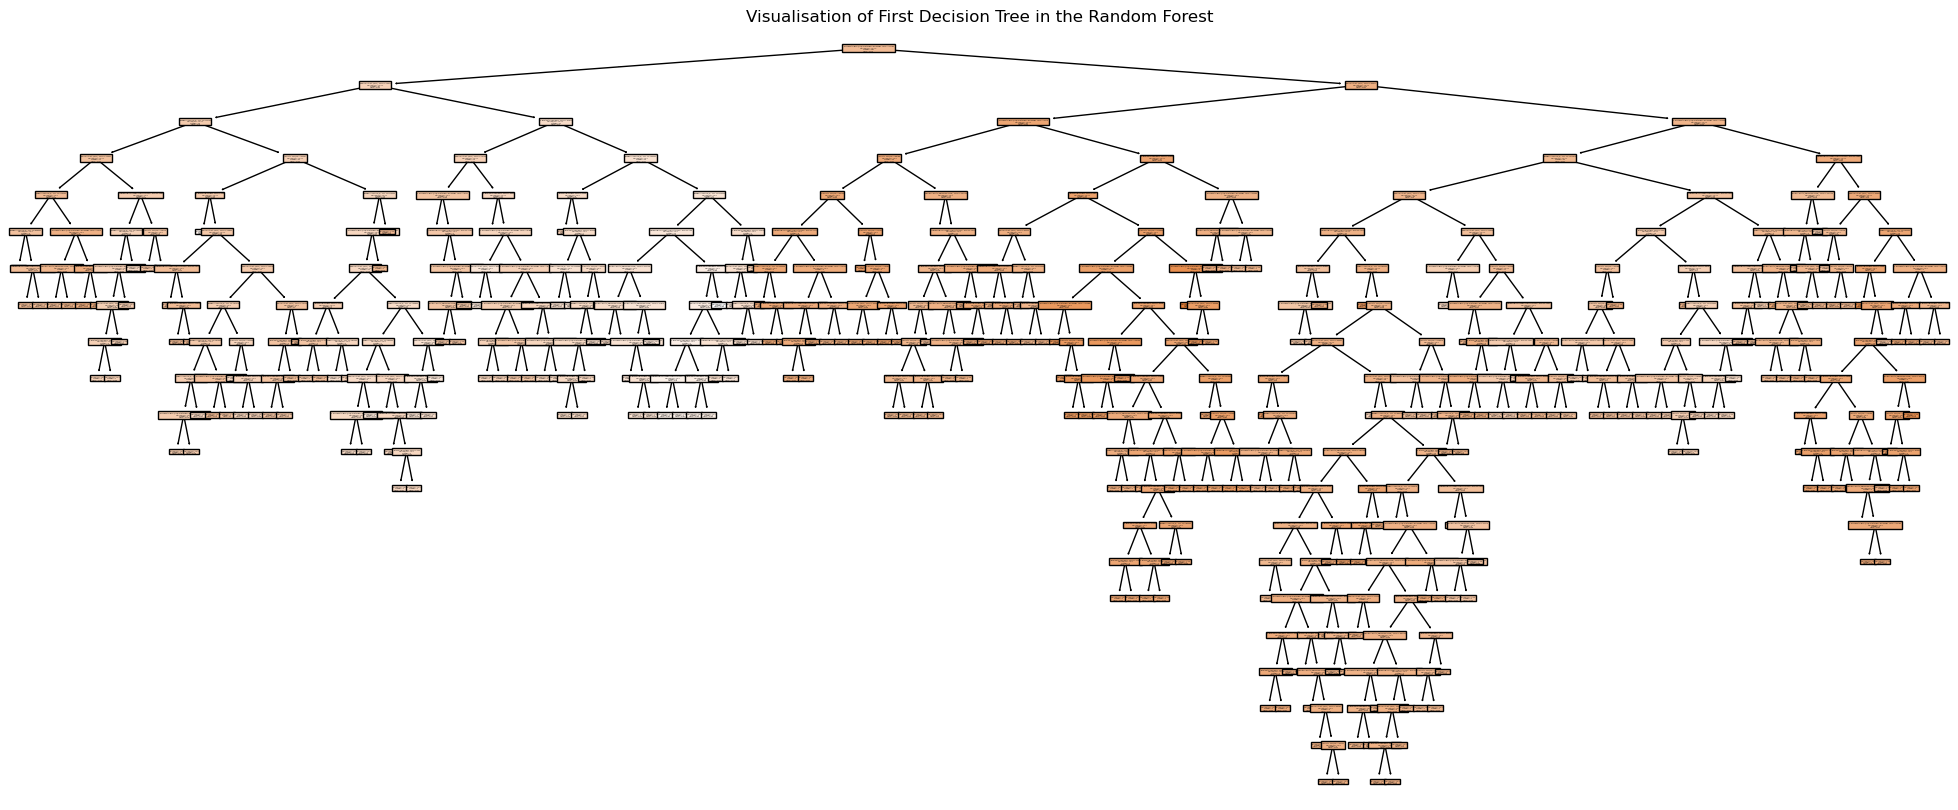

In [190]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 用最优超参数训练最终模型
rf_final = RandomForestRegressor(
    max_depth=clf.best_params_['max_depth'],
    min_samples_split=clf.best_params_['min_samples_split'],
    random_state=random_state_rf
)
rf_final.fit(train_x, train_y)

# 模型性能评估
print("R² on training set:", rf_final.score(train_x, train_y))
print("R² on test set:", rf_final.score(test_x, test_y))

# 可视化随机森林中的第一棵树
single_tree = rf_final.estimators_[0]

plt.figure(figsize=(25, 10))  # 图像尺寸可调整
plot_tree(single_tree, filled=True, feature_names=train_x.columns)
plt.title("Visualisation of First Decision Tree in the Random Forest")
plt.savefig("random_forest_tree.png", dpi=600)  # 保存为高清图片
plt.show()


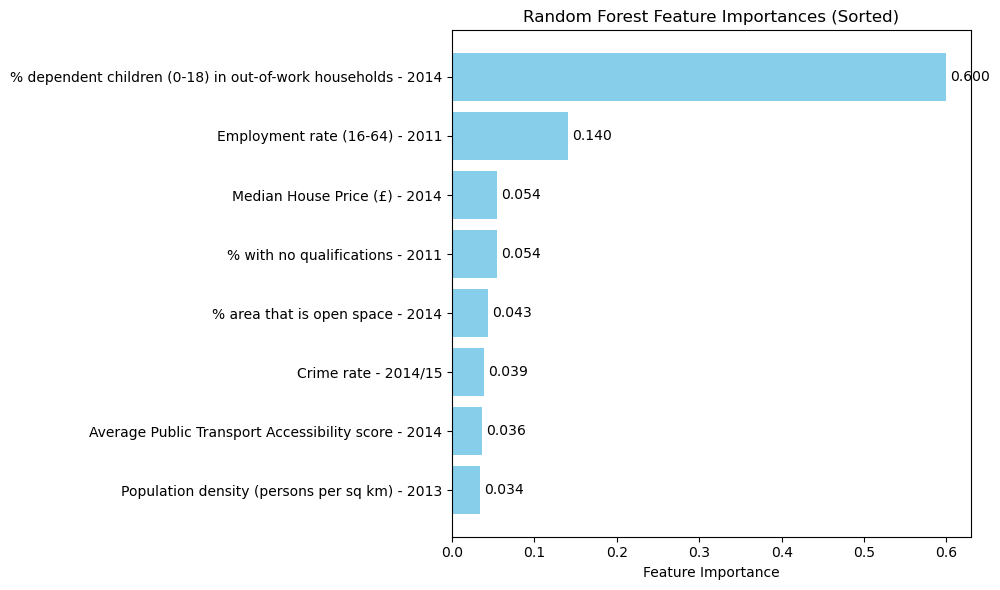

In [273]:
import matplotlib.pyplot as plt
import pandas as pd

# 获取特征重要性
importances = rf_final.feature_importances_
feature_names = train_x.columns

# 转为 DataFrame 并排序
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 可视化（按降序排列）
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 最重要的在最上面
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances (Sorted)")

# 添加数值标签
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va='center')

plt.tight_layout()
plt.show()


In [192]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 设置超参数搜索空间
hyperparameters = {
    'max_depth': [10, 20, 30, 40, 50],
    'n_estimators': [50, 100, 150, 200, 250]
}
randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

# 5 折交叉验证进行网格搜索
gscv_xgb = GridSearchCV(xgb, hyperparameters, cv=5)
gscv_xgb.fit(train_x, train_y)

# 输出最优参数与交叉验证得分
print("Best hyperparameters:", gscv_xgb.best_params_)
print("Best CV score:", gscv_xgb.best_score_)


Best hyperparameters: {'max_depth': 30, 'n_estimators': 50}
Best CV score: 0.5671451761866023


In [193]:
# 使用最优参数构建模型
xgb_final = XGBRegressor(
    max_depth=gscv_xgb.best_params_['max_depth'],
    n_estimators=gscv_xgb.best_params_['n_estimators'],
    random_state=randomState_xgb
)
xgb_final.fit(train_x, train_y)

# 输出 R² 评估
print("R² on the training data:", xgb_final.score(train_x, train_y))
print("R² on the testing data:", xgb_final.score(test_x, test_y))


R² on the training data: 0.9999127118522226
R² on the testing data: 0.5219783436962212


In [198]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 改进后的超参数搜索空间
hyperparameters = {
    'max_depth': [5, 10, 15, 20],                    # 控制模型复杂度
    'n_estimators': [50, 100, 150, 200],               # 弱学习器数量
    'learning_rate': [0.1, 0.2, 0.3],       # 学习率（步长）
    'reg_lambda': [1, 3, 5]                      # L2 正则化
}

randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

# 5 折交叉验证进行网格搜索
gscv_xgb = GridSearchCV(
    xgb,
    hyperparameters,
    cv=5       
)

# 训练模型
gscv_xgb.fit(train_x, train_y)

# 输出最优参数与交叉验证得分
print("Best hyperparameters:", gscv_xgb.best_params_)
print("Best CV score:", gscv_xgb.best_score_)


Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_lambda': 5}
Best CV score: 0.6378890831742068


In [199]:
from xgboost import XGBRegressor

# 使用最优参数构建模型
xgb_final = XGBRegressor(
    max_depth=gscv_xgb.best_params_['max_depth'],
    n_estimators=gscv_xgb.best_params_['n_estimators'],
    learning_rate=gscv_xgb.best_params_['learning_rate'],
    reg_lambda=gscv_xgb.best_params_['reg_lambda'],
    random_state=randomState_xgb
)

# 模型拟合
xgb_final.fit(train_x, train_y)

# 输出 R² 评估结果
print("R² on the training data:", xgb_final.score(train_x, train_y))
print("R² on the testing data:", xgb_final.score(test_x, test_y))


R² on the training data: 0.9156552700573781
R² on the testing data: 0.6003242185612048


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 提取重要性分数
Importances = xgb_final.feature_importances_
Feature_names = train_x.columns

# 构建 DataFrame 并按重要性排序
Importance_df = pd.DataFrame({
    'Feature': Feature_names,
    'Importance': Importances
}).sort_values(by='Importance', ascending=False)

# 可视化
plt.figure(figsize=(10, 6))
bars = plt.barh(Importance_df['Feature'], Importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 最重要的在最上面
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances (Sorted)")

# 添加数值标签
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va='center')

plt.tight_layout()
plt.show()

In [298]:
from sklearn.preprocessing import StandardScaler

# 选择用于聚类的特征
features = [
    "% dependent children (0-18) in out-of-work households - 2014",
    "% with no qualifications - 2011",
    "Employment rate (16-64) - 2011",
    "Obesity_rate"
]

# 提取并标准化
X = merged[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


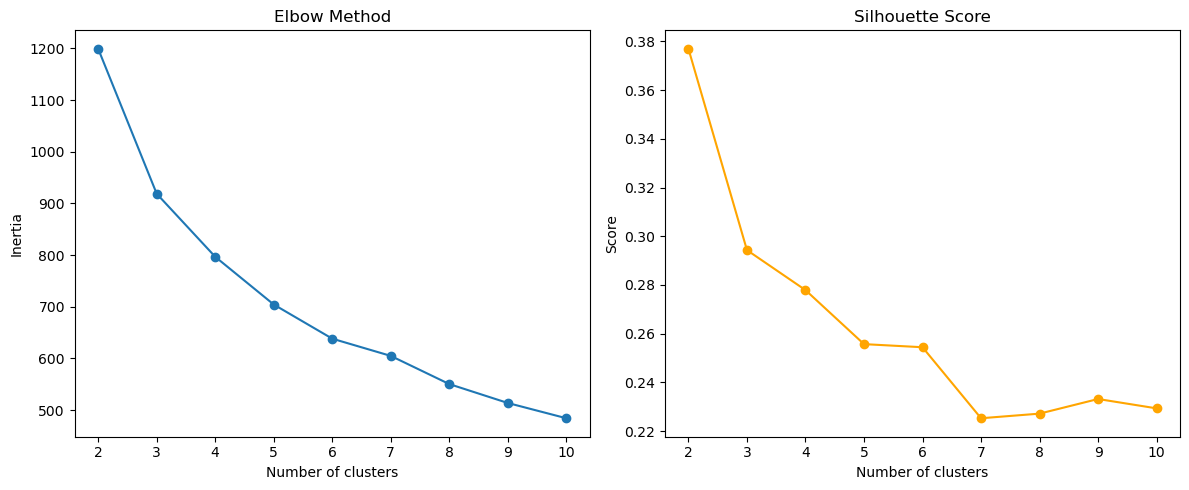

In [299]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# 可视化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


In [300]:
k = 3 # 你可以根据上图选择最优k
kmeans = KMeans(n_clusters=k, random_state=42)
merged["cluster"] = kmeans.fit_predict(X_scaled)


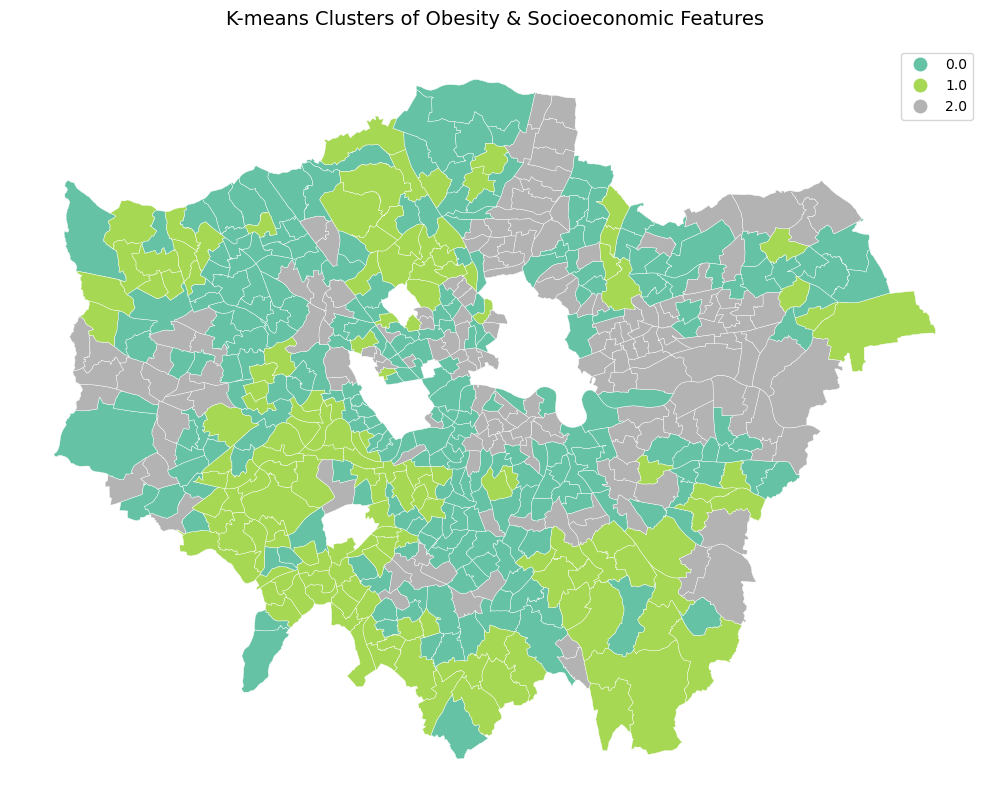

In [301]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 合并边界和聚类结果
ward_clustered = ward_boundary.merge(
    merged[["New code", "cluster"]],
    left_on="GSS_CODE",
    right_on="New code",
    how="left"
)

# 创建绘图
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制聚类地图
ward_clustered.plot(
    column="cluster",
    categorical=True,
    cmap="Set2",
    legend=True,
    edgecolor="white",     # 白色边界线更柔和
    linewidth=0.3,
    ax=ax
)

# 去掉坐标轴和外框
ax.set_axis_off()
for spine in ax.spines.values():
    spine.set_visible(False)

# 添加标题
ax.set_title("K-means Clusters of Obesity & Socioeconomic Features", fontsize=14, pad=15)

plt.tight_layout()
plt.show()



In [302]:
# 仅保留需要的列和 cluster 列
df_clustered = merged[features + ["cluster"]]

# 查看每个聚类在各特征上的均值
cluster_means = df_clustered.groupby("cluster").mean(numeric_only=True).round(3)
print("各聚类的均值：")
print(cluster_means)

# 如果想看中位数：
cluster_medians = df_clustered.groupby("cluster").median(numeric_only=True).round(3)
print("各聚类的中位数：")
print(cluster_medians)


各聚类的均值：
         % dependent children (0-18) in out-of-work households - 2014  \
cluster                                                                 
0                                                   14.965              
1                                                    7.409              
2                                                   22.469              

         % with no qualifications - 2011  Employment rate (16-64) - 2011  \
cluster                                                                    
0                                 16.976                          70.925   
1                                 12.966                          76.355   
2                                 23.050                          62.914   

         Obesity_rate  
cluster                
0               0.225  
1               0.145  
2               0.258  
各聚类的中位数：
         % dependent children (0-18) in out-of-work households - 2014  \
cluster                                    

In [303]:
cluster_counts = df_clustered["cluster"].value_counts().sort_index()
print("\n📍 每个聚类包含的选区数：")
print(cluster_counts)



📍 每个聚类包含的选区数：
cluster
0    250
1    141
2    173
Name: count, dtype: int64


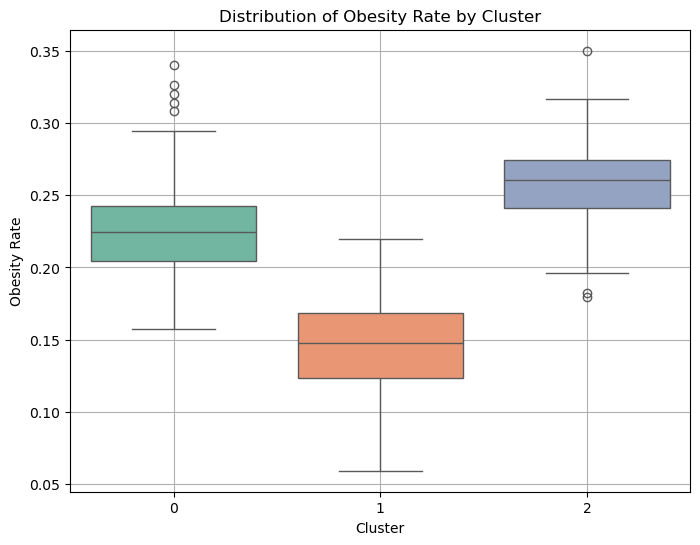

In [312]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 设置 hue="cluster"，同时关闭图例（避免重复图例）
sns.boxplot(data=df_clustered, x="cluster", y="Obesity_rate", hue="cluster", palette="Set2", dodge=False)
plt.legend().remove()  # 去除图例

plt.title("Distribution of Obesity Rate by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Obesity Rate")
plt.grid(True)
plt.show()
